<a href="https://colab.research.google.com/github/Lakshika-Swarnamali/FYP_UoM/blob/master/NMF_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
log = pd.read_csv("https://raw.githubusercontent.com/GihanKLG/TwitterCovid19Dataset/master/2020-10-12.csv",encoding='latin1')
log[(log['lang'] == 'en')].to_csv("out.csv", index=False)
log = pd.read_csv('out.csv', lineterminator='\n',encoding='latin1')
log.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Sun Oct 11 23:59:54 +0000 2020,NaN,NaN,NaN,0,1315442032651927552,BalutSmithy,1.315403e+18,1.296441e+18,en,NaN,NaN,0,NaN,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@BalutSmithy @StephenJohn59 @jaketapper @kaitl...,https://twitter.com/NorthLapp/status/131544203...,Sun Mar 25 19:25:10 +0000 2012,NorthLapp,False,"I need more followers, I will expose the truth...",1979,1291,1805,28,NaN,Renee J North Lapp,NorthLapp,12503,NaN,NaN,False
1,NaN,Sun Oct 11 23:59:56 +0000 2020,NaN,NaN,NaN,0,1315442037286678529,NaN,NaN,NaN,en,NaN,NaN,1,1.315348e+18,PetraCEsser1,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @PetraCEsser1: @HSRetoucher Thank you. I am...,https://twitter.com/johncoppa44/status/1315442...,Fri Feb 26 09:25:23 +0000 2016,johncoppa44,True,NaN,3031,31,287,1,NaN,john coppa,johncoppa44,7490,NaN,NaN,False
2,NaN,Sun Oct 11 23:59:56 +0000 2020,NaN,NaN,https://twitter.com/onlinelonghorn/status/1315...,0,1315442039870324736,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",*corona liked this post* https://t.co/3mAPNWNAfK,https://twitter.com/ivythekingrat/status/13154...,Mon Dec 11 16:09:37 +0000 2017,ivythekingrat,False,nope,4001,95,153,0,puerto rico,rat zone,ivythekingrat,1633,NaN,NaN,False
3,NaN,Sun Oct 11 23:59:55 +0000 2020,SidNaaz,NaN,NaN,0,1315442036028260353,NaN,NaN,NaN,en,NaN,NaN,120,1.315334e+18,SidNaaz13Dstny,"<a href=""http://twitter.com/download/android"" ...",RT @SidNaaz13Dstny: Points\n\n1. Salman Sir #S...,https://twitter.com/Tejakshi1/status/131544203...,Sat Jan 04 06:50:54 +0000 2020,Tejakshi1,False,Ã°ÂÂ¤Â¡,57815,282,579,0,NaN,tejakshi shetty,Tejakshi1,39117,NaN,NaN,False
4,NaN,Sun Oct 11 23:59:55 +0000 2020,NaN,NaN,NaN,0,1315442033331507203,NaN,NaN,NaN,en,NaN,NaN,10711,1.315345e+18,CLewandowski_,"<a href=""http://twitter.com/#!/download/ipad"" ...",RT @CLewandowski_: WHO now advising against lo...,https://twitter.com/LoisR52511816/status/13154...,Sun Aug 02 16:10:47 +0000 2020,LoisR52511816,True,NaN,28886,88,277,0,NaN,LoisR,LoisR52511816,13602,NaN,NaN,False


In [3]:
# importing pandas package
import pandas as pd
 
# making data frame from csv file
data = pd.read_csv("https://raw.githubusercontent.com/GihanKLG/TwitterCovid19Dataset/master/2020-10-12.csv", index_col ="id")
 
# retrieving columns by indexing operator
my_column_names = [ 'user_name','text']
df = pd.DataFrame(data=data, columns=my_column_names)
lda = pd.DataFrame(data=data, columns=my_column_names)
documents = pd.DataFrame(data=data, columns=my_column_names)

df.head(10)

,user_name,text
id,,
1315442032651927552,Renee J North Lapp,@BalutSmithy @StephenJohn59 @jaketapper @kaitl...
1315442033507684352,🎃 leh 🎃,RT @dougraz: todo dia pensando será se eu ja p...
1315442037286678529,john coppa,RT @PetraCEsser1: @HSRetoucher Thank you. I am...
1315442040172425216,Reivindicación,@PedroAzzola https://t.co/RxL0DAaQaI
1315442039870324736,rat zone,*corona liked this post* https://t.co/3mAPNWNAfK
1315442032350027780,ᴮᴱ#LAKERS 2020 NBA Champions #Titans (5-0),https://t.co/VNNyjhzXxt https://t.co/DRIUE2K2VV
1315442036028260353,tejakshi shetty,RT @SidNaaz13Dstny: Points\n\n1. Salman Sir #S...
1315442038142390274,Angel Duarte Hurtado,RT @AristeguiOnline: Paga México más de 180 mi...
1315442033331507203,LoisR,RT @CLewandowski_: WHO now advising against lo...


In [4]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
def remove_links(text):
    '''Takes a string and removes web links from it'''
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    return text

def remove_users(text):
    '''Takes a string and removes retweet and @user information'''
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove retweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove tweeted at
    return text

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(text, bigrams=False):
    text = remove_users(text)
    text = remove_links(text)
    text = text.lower() # lower case
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    tweet_token_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [31]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['seems', 'to', 'me', 'that', 'fauci', 'is', 'also', 'to', 'blame', 'for', 'the', 'mishandling', 'of', 'this', 'pandemic', 'birx', 'too', 'pres', 'listened', 'to', 'their', 'advice', 'of', 'what', 'to', 'do', 'when', 'to', 'do', 'it', 'the', 'pres', 'isnt', 'doctor', 'fauci', 'led', 'his', 'team', 'do', 'you', 'blame', 'fauci', 'so', 'why', 'do', 'you', 'trust', 'fauci', 'he', 'has', 'changed', 'his', 'opinion', 'often']]


In [32]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [8]:
documents['clean_tweet'] = documents.text.apply(clean_tweet)
documents.head()

,user_name,text,clean_tweet
id,,,
1315442032651927552,Renee J North Lapp,@BalutSmithy @StephenJohn59 @jaketapper @kaitl...,seem fauci also blame mishandl pandem birx pr...
1315442033507684352,🎃 leh 🎃,RT @dougraz: todo dia pensando será se eu ja p...,todo dia pensando será se eu ja peguei covid ...
1315442037286678529,john coppa,RT @PetraCEsser1: @HSRetoucher Thank you. I am...,thank speak tongu angel bring chip blood brai...
1315442040172425216,Reivindicación,@PedroAzzola https://t.co/RxL0DAaQaI,
1315442039870324736,rat zone,*corona liked this post* https://t.co/3mAPNWNAfK,corona like post


In [9]:
# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=50, stop_words='english')
 
# Fit and transform
X = vect.fit_transform(documents.clean_tweet)

In [10]:
# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=10, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

In [11]:
X.shape

(166536, 3802)

In [12]:
nmf_features.shape

(166536, 10)

In [13]:
model.components_.shape

(10, 3802)

In [14]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())
components_df

,ab,aban,abc,abil,abl,abo,abort,absolut,abuja,abus,aca,acab,acaba,acabar,accept,access,accident,accion,accord,account,accur,accus,acerca,achiev,acknowledg,act,action,activ,activo,actor,actual,actualización,acuerdo,acumulado,acá,ad,ada,adalah,adam,adapt,...,วน,วนจากโคว,วย,สถานศ,สทำร,สอดประกาศให,หนวกถาวรไปข,หล,หายท,อนข,อนเด,อว,อเคสผ,าง,าทำไมข,ายห,าวน,าวล,าไวร,เจอเคสห,เช,เด,เร,เศษ,เอะอะก,แต,แม,แล,ใช,ในประเทศม,ในว,ไปเจอผ,ๆๆๆ,메신저,사랑의,평화와,𝐂𝐎𝐍𝐓𝐈𝐆𝐎,𝐄𝐒,𝙄𝙣𝙛𝙤,𝙧𝙢𝙖𝙩𝙚
0,0.000000,0.000000,0.000000,0.000425,1.768226e-03,0.000000,7.810381e-04,2.676618e-03,0.000000,9.496168e-04,0.000652,0.000000,0.000000,0.000000,1.993130e-03,0.001339,0.000000,0.000000,2.222069e-02,0.001955,5.755285e-04,0.000502,0.000000,1.883796e-04,0.000000,2.145653e-03,2.153082e-03,0.000000e+00,0.000000,0.000068,3.849573e-03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000059,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000059,0.000000,0.000000,0.000000,0.000266,0.000266,0.000000,0.000000
1,0.004426,0.003426,0.011679,0.000954,1.339907e-04,0.000000,1.635612e-03,0.000000e+00,0.000000,4.357375e-04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000291,0.000000,0.000000,0.000000e+00,0.000299,0.000000e+00,0.004937,0.000000,9.151420e-04,0.000000,6.689695e-04,0.000000e+00,5.851620e-04,0.000000,0.000000,2.970812e-03,0.000000,0.000000e+00,0.000000,0.000000,2.570722,0.000000,0.000262,0.000000,0.000305,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.001049,2.331705e-03,0.000000,9.815260e-06,1.067821e-03,0.000149,2.589653e-04,0.001259,0.000000,0.000000,0.000000,2.931688e-04,0.001086,0.000000,0.000000,0.000000e+00,0.001287,5.484563e-04,0.000000,0.000000,1.412434e-04,0.000000,3.092409e-03,3.470145e-03,3.045954e-02,0.000000,0.000604,2.955888e-03,0.000000,0.000000e+00,0.000000,0.000000,0.009910,0.000815,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.004735,0.018839,0.001959,0.012621,5.279686e-02,0.002242,8.273523e-03,3.453425e-02,0.003677,9.597005e-03,0.080053,0.010138,0.000000,0.000654,1.133753e-02,0.011238,0.020881,0.003699,2.674725e-02,0.020284,1.892808e-02,0.013518,0.001331,5.017754e-03,0.065318,3.950119e-02,4.151173e-02,1.489942e-01,0.008215,0.005140,5.437807e-02,0.014600,0.000000e+00,0.004683,0.000000,0.000000,0.032043,0.005485,0.009096,0.007870,...,0.035749,0.000058,0.006667,0.035749,0.000058,0.035749,0.000058,0.016784,0.000058,0.000058,0.000539,0.000058,0.006667,0.000058,0.006667,0.000058,0.006667,0.000058,0.000494,0.000058,0.001466,0.002753,0.036,0.035749,0.000539,0.002614,0.037204,0.037722,0.003847,0.006667,0.035773,0.006667,0.000539,0.000000,0.000000,0.000000,0.000000,0.000000,0.002519,0.002519
4,0.000000,0.000000,0.004608,0.000000,0.000000e+00,0.000056,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.038081,0.026876,0.012306,0.000000e+00,0.000000,0.005667,0.044605,0.000000e+00,0.000000,0.000000e+00,0.000000,0.036904,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.037790,0.016012,2.689921e-03,0.104244,3.172564e-02,0.025949,0.045128,0.000412,0.000457,0.000181,0.000000,0.000000,...,0.000000,0.000000,0.000

In [15]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
doe         2.694841
wear        2.686319
woman       2.685614
straight    2.683249
choic       2.679073
save        2.663883
mask        2.661486
person      2.617069
let         2.563171
live        2.542178
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
context     2.581577
ad          2.570722
pathet      2.469364
wit         2.455725
comment     2.453204
latest      2.446828
use         2.365979
amp         2.293940
campaign    2.246847
fauci       2.245425
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
song        4.679170
hear        4.287498
pandem      3.344844
graham      0.108669
lindsey     0.107556
chair       0.103243
tomorrow    0.102755
advanc      0.097645
trum        0.097048
refus       0.090840
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
covid       7.313813
test        1.371351
neg         0.845082
peopl       0.826336
case    

In [16]:
tweets = pd.DataFrame(df)
def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
# make new columns for mentioned usernames and hashtags
tweets['mentioned'] = tweets.text.apply(find_mentioned)
tweets['hashtags'] = tweets.text.apply(find_hashtags)
tweets.head(5)

,user_name,text,mentioned,hashtags
id,,,,
1315442032651927552,Renee J North Lapp,@BalutSmithy @StephenJohn59 @jaketapper @kaitl...,"[@BalutSmithy, @StephenJohn59, @jaketapper, @k...",[]
1315442033507684352,🎃 leh 🎃,RT @dougraz: todo dia pensando será se eu ja p...,[],[]
1315442037286678529,john coppa,RT @PetraCEsser1: @HSRetoucher Thank you. I am...,[@HSRetoucher],[]
1315442040172425216,Reivindicación,@PedroAzzola https://t.co/RxL0DAaQaI,[@PedroAzzola],[]
1315442039870324736,rat zone,*corona liked this post* https://t.co/3mAPNWNAfK,[],[]


In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.037*"day" + 0.031*"new" + 0.027*"tell" + 0.026*"die" + 0.025*"vote" + 0.022*"case" + 0.015*"lie" + 0.014*"thing" + 0.012*"number" + 0.011*"today"'), (1, '0.105*"pandemic" + 0.066*"mask" + 0.045*"let" + 0.030*"save_live" + 0.029*"woman_doe" + 0.027*"wear" + 0.016*"month" + 0.014*"oppress" + 0.014*"immune" + 0.013*"give"'), (2, '0.054*"people" + 0.027*"test" + 0.020*"time" + 0.018*"work" + 0.015*"show" + 0.012*"break" + 0.012*"state" + 0.010*"positive" + 0.010*"really" + 0.009*"negative"'), (3, '0.138*"covid" + 0.061*"trump" + 0.052*"campaign" + 0.037*"ad" + 0.037*"president" + 0.034*"amp" + 0.031*"context" + 0.027*"late" + 0.025*"comment" + 0.022*"virus"'), (4, '0.170*"co" + 0.048*"lockdown" + 0.041*"https" + 0.021*"support" + 0.021*"http" + 0.019*"force" + 0.017*"silent" + 0.014*"call" + 0.011*"plan" + 0.009*"ask"')]


In [29]:
hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
# print(hashtags_list_df.head(20))

In [28]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
# print(flattened_hashtags_df.head(20))

In [27]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

# print(popular_hashtags.head(20))

In [20]:
# take hashtags which appear at least this amount of times
min_appearance = 150
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

print(popular_hashtags_set)

{'#EnVideo', '#EndSARS', '#They', '#COVID__19', '#Desantis', '#coronavirus', '#COVID19', '#OpsYustisiPoldaSulsel', '#EnCombateContraElCovid19', '#Coronavirus', '#IndahnyaBerbagi', '#WearAMask', '#TyphoidMary', '#Trump', '#KapoldaSulsel', '#MAGA', '#andrewcuomo', '#lockdown', '#scamdemic', '#TrumpCovid', '#WHO', '#ORLANDOFLORIDA', '#COVID', '#SARSMUSTEND', '#COvId19', '#Covid', '#TaatiProkesHindariKerumunan', '#covid19', '#Covid19', '#vote', '#EnVivo'}


In [26]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

# print(popular_hashtags_list_df.head(20))

In [25]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

# print(hashtag_vector_df.head(20))

                              #EnVideo  #EndSARS  ...     #vote   #EnVivo
#EnVideo                      1.000000 -0.016278  ... -0.015652 -0.021257
#EndSARS                     -0.016278  1.000000  ... -0.012888 -0.017502
#They                        -0.018584 -0.015302  ... -0.014713 -0.019981
#COVID__19                   -0.021927 -0.018054  ... -0.017359 -0.023575
#Desantis                    -0.018719 -0.015413  ... -0.014820 -0.020127
#coronavirus                 -0.042545 -0.035030  ... -0.033683 -0.035718
#COVID19                     -0.129820 -0.106042  ... -0.101517 -0.124857
#OpsYustisiPoldaSulsel       -0.020567 -0.016935  ... -0.016283 -0.022114
#EnCombateContraElCovid19     0.036538 -0.019890  ... -0.019125 -0.025973
#Coronavirus                 -0.030528 -0.025136  ... -0.024169 -0.030143
#IndahnyaBerbagi             -0.020567 -0.016935  ... -0.016283 -0.022114
#WearAMask                   -0.020567 -0.016935  ...  0.004584 -0.022114
#TyphoidMary                 -0.018173

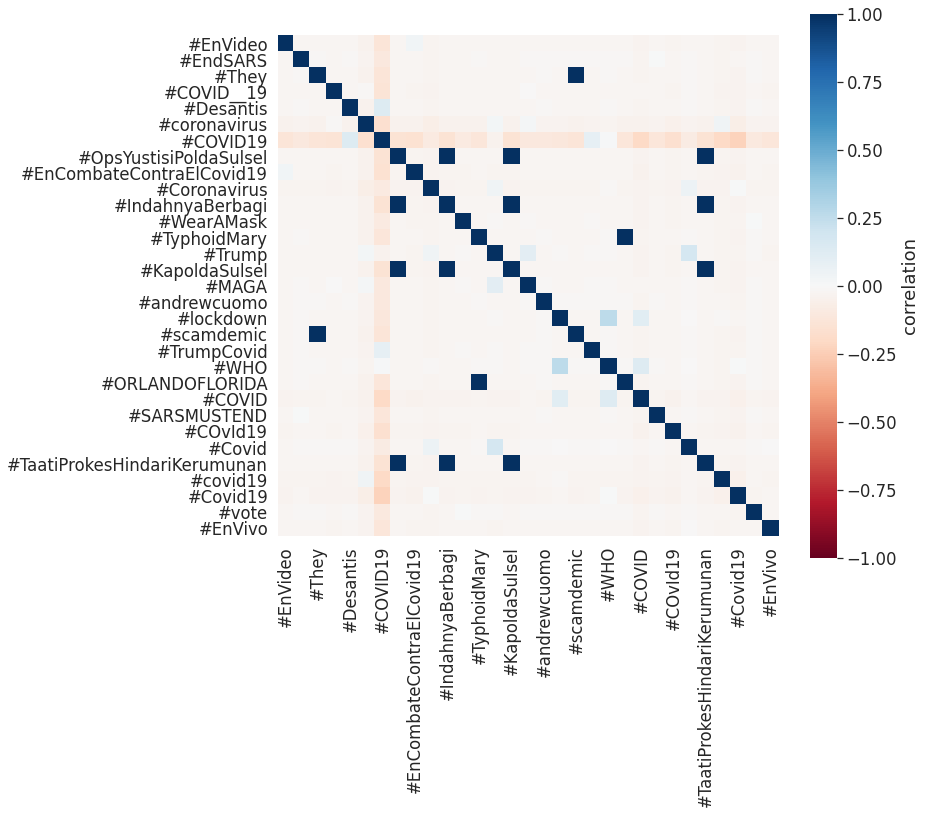

In [23]:
import seaborn as sn
import matplotlib.pyplot as plt

hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

# calculate the correlation matrix
correlations = hashtag_matrix.corr()
print (correlations)
# # plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
     cmap='RdBu',
     vmin=-1,
     vmax=1,
     square = True,
     cbar_kws={'label':'correlation'})
plt.show()

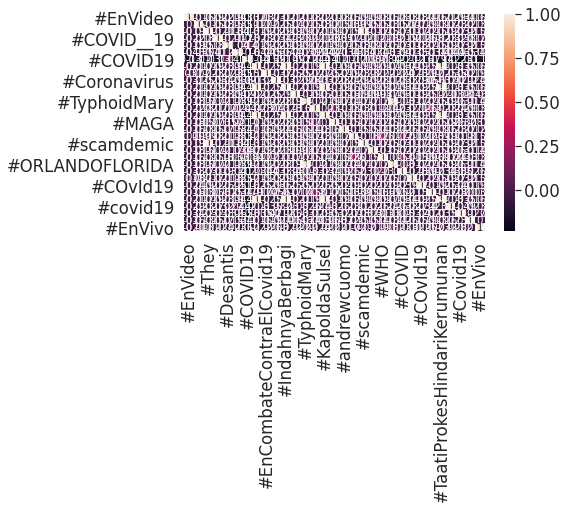

In [24]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(correlations, annot=True)
plt.show()

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_nmf = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score: ', coherence_nmf)


Perplexity:  -8.000311683163526

Coherence Score:  0.29888898430591077
